## Lab 07: Computer Vision I: Deep Neural Nets in FASHION MNIST

Build a neural network for multiclass classification on the Fashion mnist dataset. Compare the effectiveness of neural networks with different parameters.

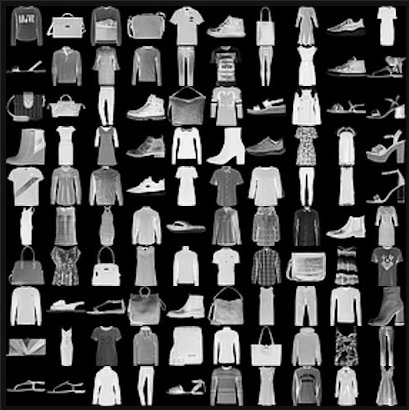 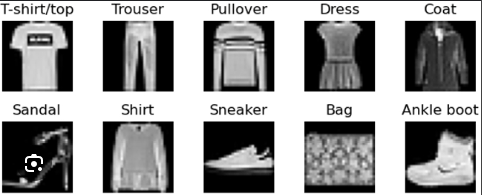  

### PREPROCESSING


In [1]:
# import packages
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [2]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define a transformation to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

In [4]:
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)


100%|██████████| 26421880/26421880 [00:02<00:00, 11607642.03it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210044.70it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3941341.15it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4638512.78it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



In [5]:
# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


In [6]:
trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /root/.pytorch/F_MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [7]:
testset

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /root/.pytorch/F_MNIST_data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

BUILD NEURAL NETWORK

In [8]:
class Net(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, activation_func):
        super(Net, self).__init__()
        # Initialize hidden layers
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])

        # Initialize output layer
        self.output = nn.Linear(hidden_layers[-1], output_size)

        # Initialize batch normalization layers
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(num_features=hidden_size) for hidden_size in hidden_layers])

        # Activation function
        self.activation_dict = {
            'relu': F.relu,
            'sigmoid': torch.sigmoid
        }
        self.activation_func = self.activation_dict.get(activation_func, F.relu)

    def forward(self, x):
        # Flatten the input
        x = x.view(x.shape[0], -1)

        # Apply layers with batch normalization and activation
        for i, layer in enumerate(self.hidden_layers):
            x = layer(x)
            x = self.batch_norms[i](x)
            x = self.activation_func(x)

        # Apply the output layer
        x = self.output(x)

        return x


In [9]:
# Define the experiments
experiments = [
    {'num_layers': 2, 'neurons_per_layer': [128, 64], 'activation': 'relu'},
    {'num_layers': 3, 'neurons_per_layer': [256, 128, 64], 'activation': 'relu'},
    {'num_layers': 2, 'neurons_per_layer': [128, 64], 'activation': 'sigmoid'},
    {'num_layers': 3, 'neurons_per_layer': [256, 128, 64], 'activation': 'sigmoid'},
]

### TRAIN AND TEST PROCESS

In [10]:
input_size = 784  # 28x28 images
output_size = 10  # 10 classes for Fashion MNIST

experiment_results = []

for experiment in experiments:
    print(f"Running experiment with {experiment['num_layers']} layers, "
          f"neurons per layer: {experiment['neurons_per_layer']}, "
          f"activation: {experiment['activation']}")

    model = Net(input_size=input_size,
                output_size=output_size,
                hidden_layers=experiment['neurons_per_layer'],
                activation_func=experiment['activation']).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Training
    num_epochs = 10
    epoch_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}")

    # Testing
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")

    experiment_results.append({
        'experiment': experiment,
        'losses': epoch_losses,
        'accuracy': accuracy
    })


Running experiment with 2 layers, neurons per layer: [128, 64], activation: relu
Epoch 1/10, Loss: 0.48054976030580526
Epoch 2/10, Loss: 0.35034908265320225
Epoch 3/10, Loss: 0.3155693257573063
Epoch 4/10, Loss: 0.29237556610026083
Epoch 5/10, Loss: 0.2725196561849575
Epoch 6/10, Loss: 0.2602046961500955
Epoch 7/10, Loss: 0.24474794964895827
Epoch 8/10, Loss: 0.2360085856590444
Epoch 9/10, Loss: 0.22656755482972557
Epoch 10/10, Loss: 0.2151882859117695
Accuracy: 0.8874
Running experiment with 3 layers, neurons per layer: [256, 128, 64], activation: relu
Epoch 1/10, Loss: 0.4749700556844791
Epoch 2/10, Loss: 0.3452241365938807
Epoch 3/10, Loss: 0.30569499333117056
Epoch 4/10, Loss: 0.2841901723255735
Epoch 5/10, Loss: 0.2606764182543704
Epoch 6/10, Loss: 0.24597894243085816
Epoch 7/10, Loss: 0.22824939655692084
Epoch 8/10, Loss: 0.2168640919736644
Epoch 9/10, Loss: 0.20489512437156268
Epoch 10/10, Loss: 0.19416909357076134
Accuracy: 0.8834
Running experiment with 2 layers, neurons per l

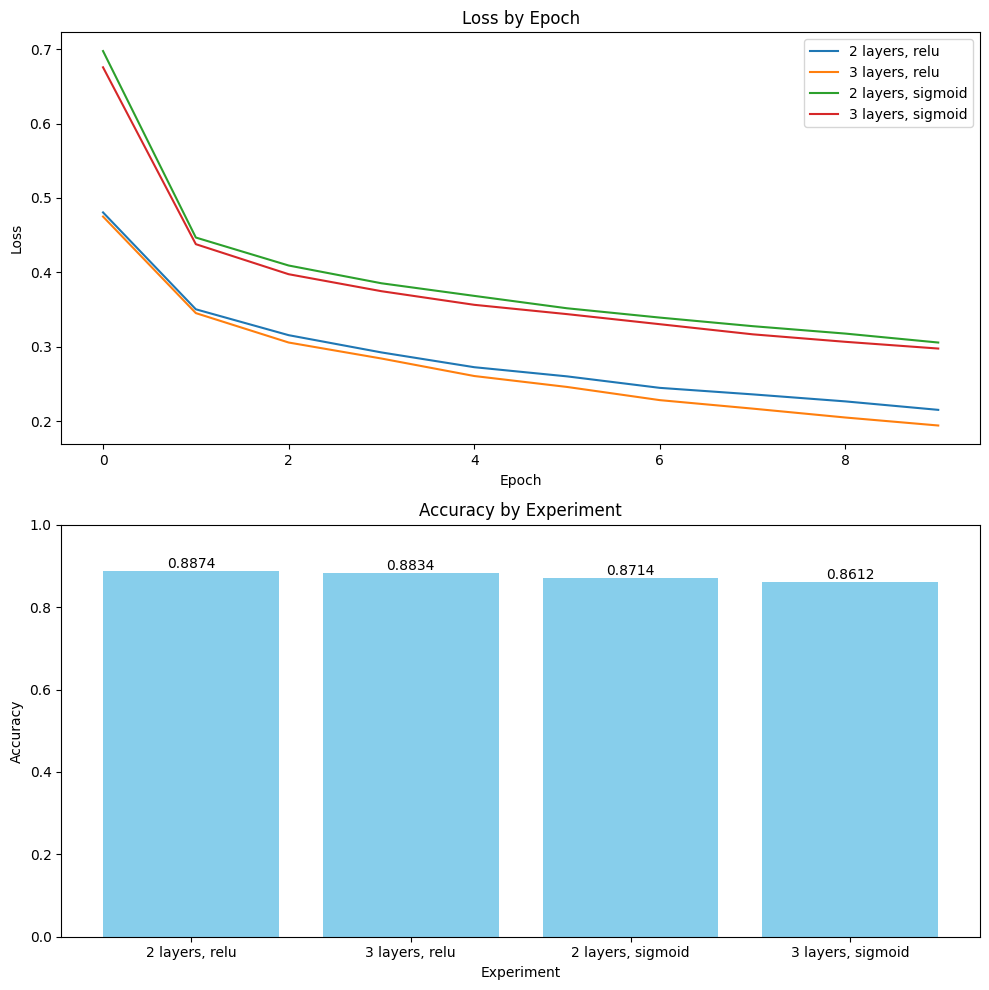

In [13]:
# Plotting the results
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot loss by epoch for each experiment
for result in experiment_results:
    experiment = result['experiment']
    axes[0].plot(result['losses'], label=f"{experiment['num_layers']} layers, {experiment['activation']}")
axes[0].set_title('Loss by Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot accuracy for each experiment
accuracies = [result['accuracy'] for result in experiment_results]
experiment_labels = [f"{exp['num_layers']} layers, {exp['activation']}" for exp in experiments]
bars = axes[1].bar(experiment_labels, accuracies, color='skyblue')
axes[1].set_title('Accuracy by Experiment')
axes[1].set_xlabel('Experiment')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0, 1)

# Annotate each bar with its accuracy value
for bar, accuracy in zip(bars, accuracies):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height, f'{accuracy:.4f}', ha='center', va='bottom')


plt.tight_layout()
plt.show()